# Llama 2 Document Assistant

#### Project : Made a chatbot based on Llama 2 which answers based on the pdf shown to it. The Chatbot is deployed on Flask

#### Project Steps:
1. We have shown the usage as a medical chatbot but the logic can be extended to use it in any other domain for helping in reading pdfs.
2. Read the pdf using pypdf .
3. Text chunking done using Langchain
4. Created embeddings using the hugging face's transformer : sentence-transformers/all-MiniLM-L6-v
5. Stored the embeddings in Pinecone
6. Made a prompt using Langchain and fed to Llama 2 model to find similarity (cosine similarity) in the embeddings created
7. The output is based on the top 2 most similar chunks and generated using the Llama 2
8. Deployed this on Flask where the front end runs.

In [1]:
#Importing all the necessary libraries

from langchain import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Pinecone
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore
# import pinecone
from sentence_transformers import SentenceTransformer
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.llms import CTransformers
import os

c:\Users\rajha\anaconda3\envs\chatbot\lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# API Key for Pinecone Vector Database
os.environ['PINECONE_API_KEY'] = "f284c621-335b-4a06-8614-0df7def26671"
pc = Pinecone(api_key = "f284c621-335b-4a06-8614-0df7def26671")

In [3]:
index_name = "financechatbot"
# connect to index
index = pc.Index(index_name)

In [4]:
# view index stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 7764}},
 'total_vector_count': 7764}

In [5]:
#Extract data from the PDF
def load_pdf(data):
    loader = DirectoryLoader(data,
                    glob="*.pdf",
                    loader_cls=PyPDFLoader)
    
    documents = loader.load()

    return documents

In [6]:
# extracted_data
extracted_data = load_pdf("data/")

In [7]:
#Create text chunks
def text_split(extracted_data):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 20)
    text_chunks = text_splitter.split_documents(extracted_data)

    return text_chunks

In [8]:
text_chunks = text_split(extracted_data)
print("Length of my Chunk:", len(text_chunks))

Length of my Chunk: 7020


In [9]:
#download embedding model
def download_hugging_face_embeddings():
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return embeddings

In [10]:
embeddings = download_hugging_face_embeddings()
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [11]:
query_result = embeddings.embed_query("Hello world")
print("Length", len(query_result))

Length 384


In [12]:
# #Creating Embeddings for Each of The Text Chunks & storing
# docsearch=PineconeVectorStore.from_texts([t.page_content for t in text_chunks], embeddings, index_name=index_name)

In [13]:
# view index stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 7764}},
 'total_vector_count': 7764}

In [14]:
#If we already have an index we can load it like this
docsearch=PineconeVectorStore.from_existing_index(index_name, embeddings)
docsearch

In [15]:
#Prompt Template
prompt_template="""
Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer below and nothing else.
Helpful answer:
"""

In [16]:
PROMPT=PromptTemplate(template=prompt_template, input_variables=["context", "question"])
chain_type_kwargs={"prompt": PROMPT}

In [17]:
#Configuring Llama LLM for generating output response
llm=CTransformers(model="model\llama-2-7b-chat.ggmlv3.q4_0.bin",
                  model_type="llama",
                  config={'max_new_tokens':512,
                          'temperature':0.8})

In [18]:
qa=RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=docsearch.as_retriever(search_kwargs={'k': 2}),
    return_source_documents=True, 
    chain_type_kwargs=chain_type_kwargs)

In [ ]:
#Passing Input Prompt and generating Response
while True:
    user_input=input(f"Input Prompt:")
    result=qa({"query": user_input})
    print("Response : ", result["result"])

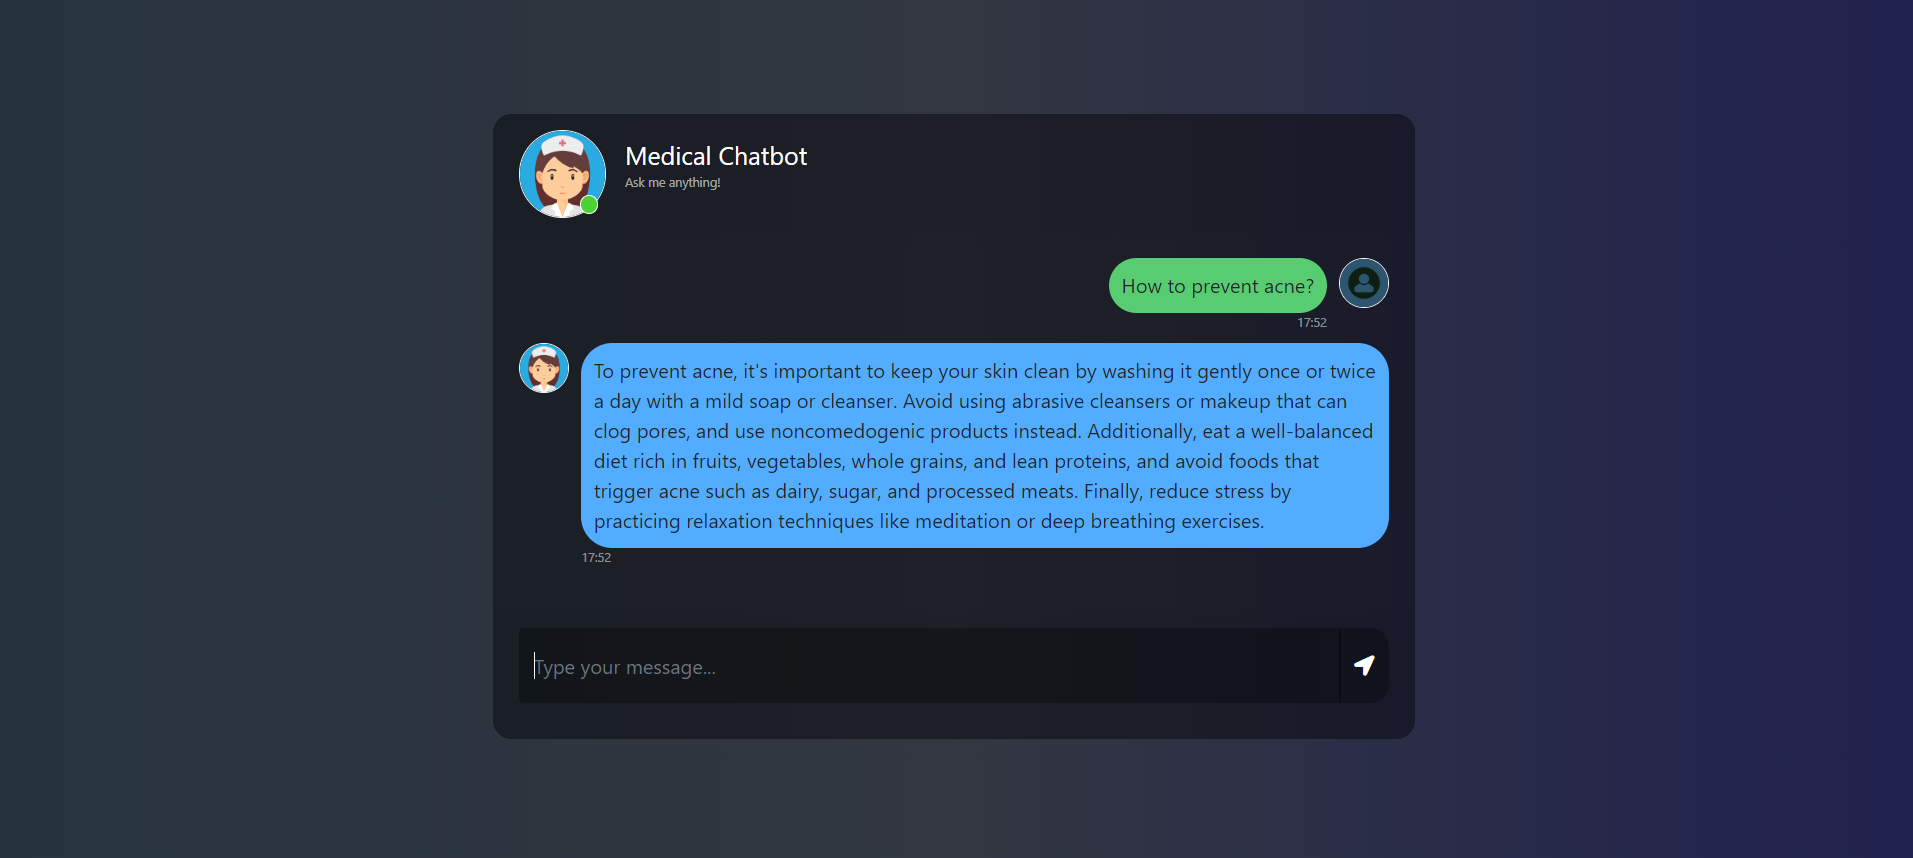

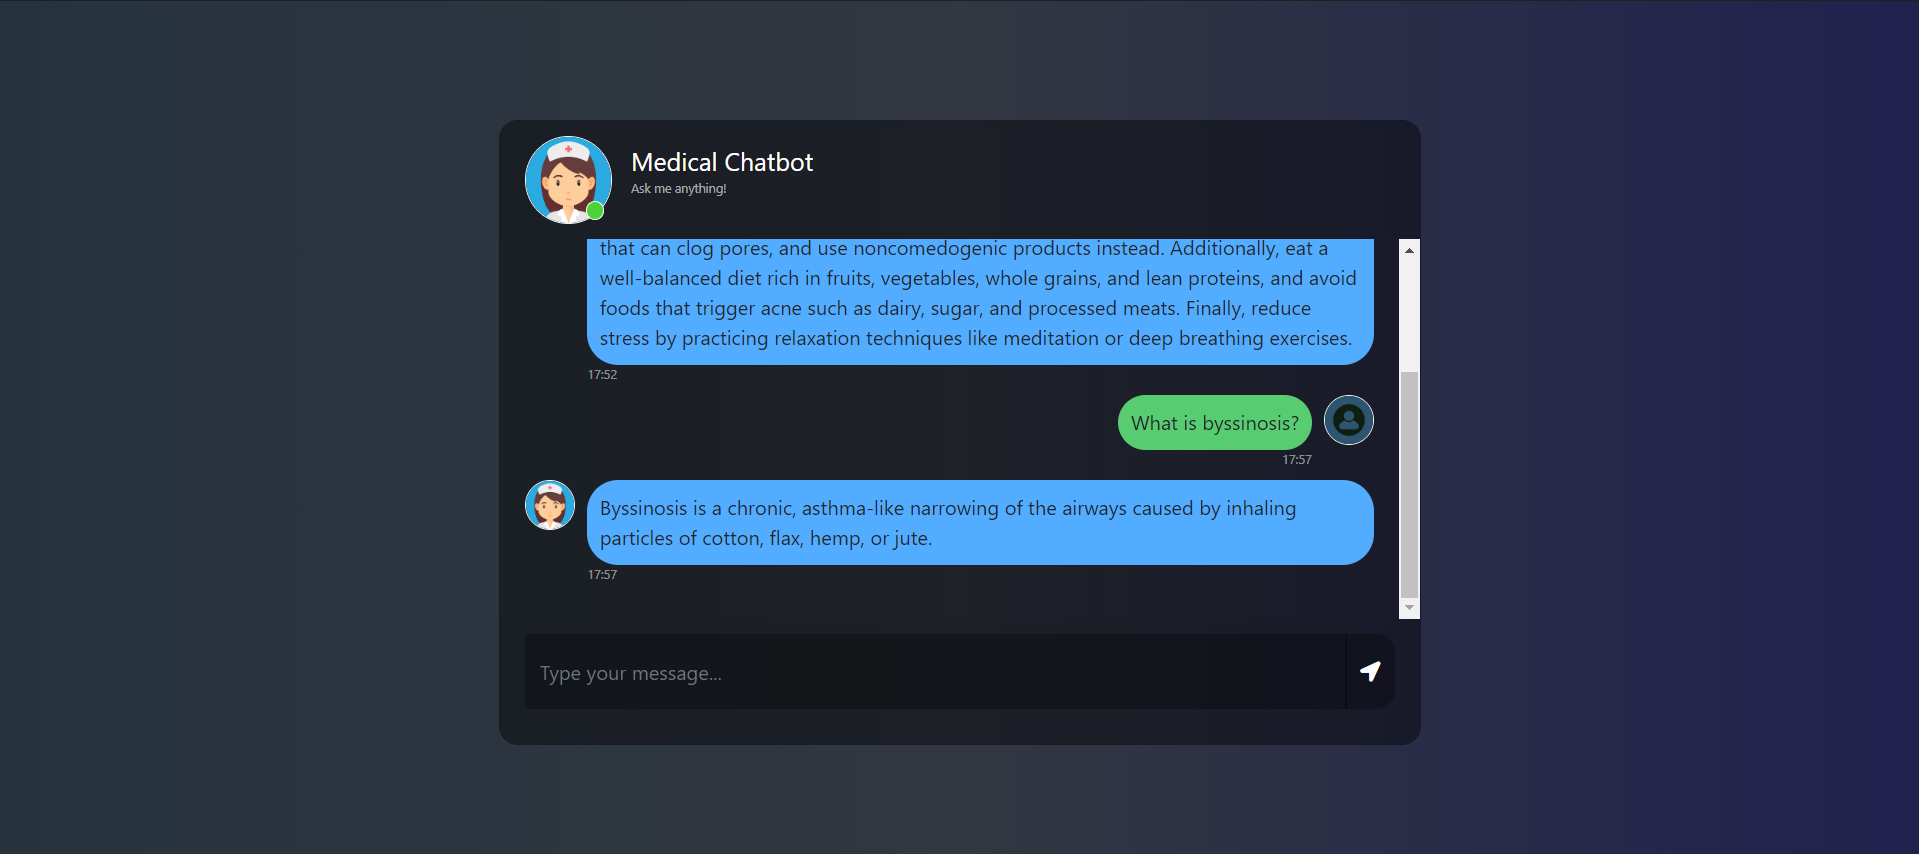

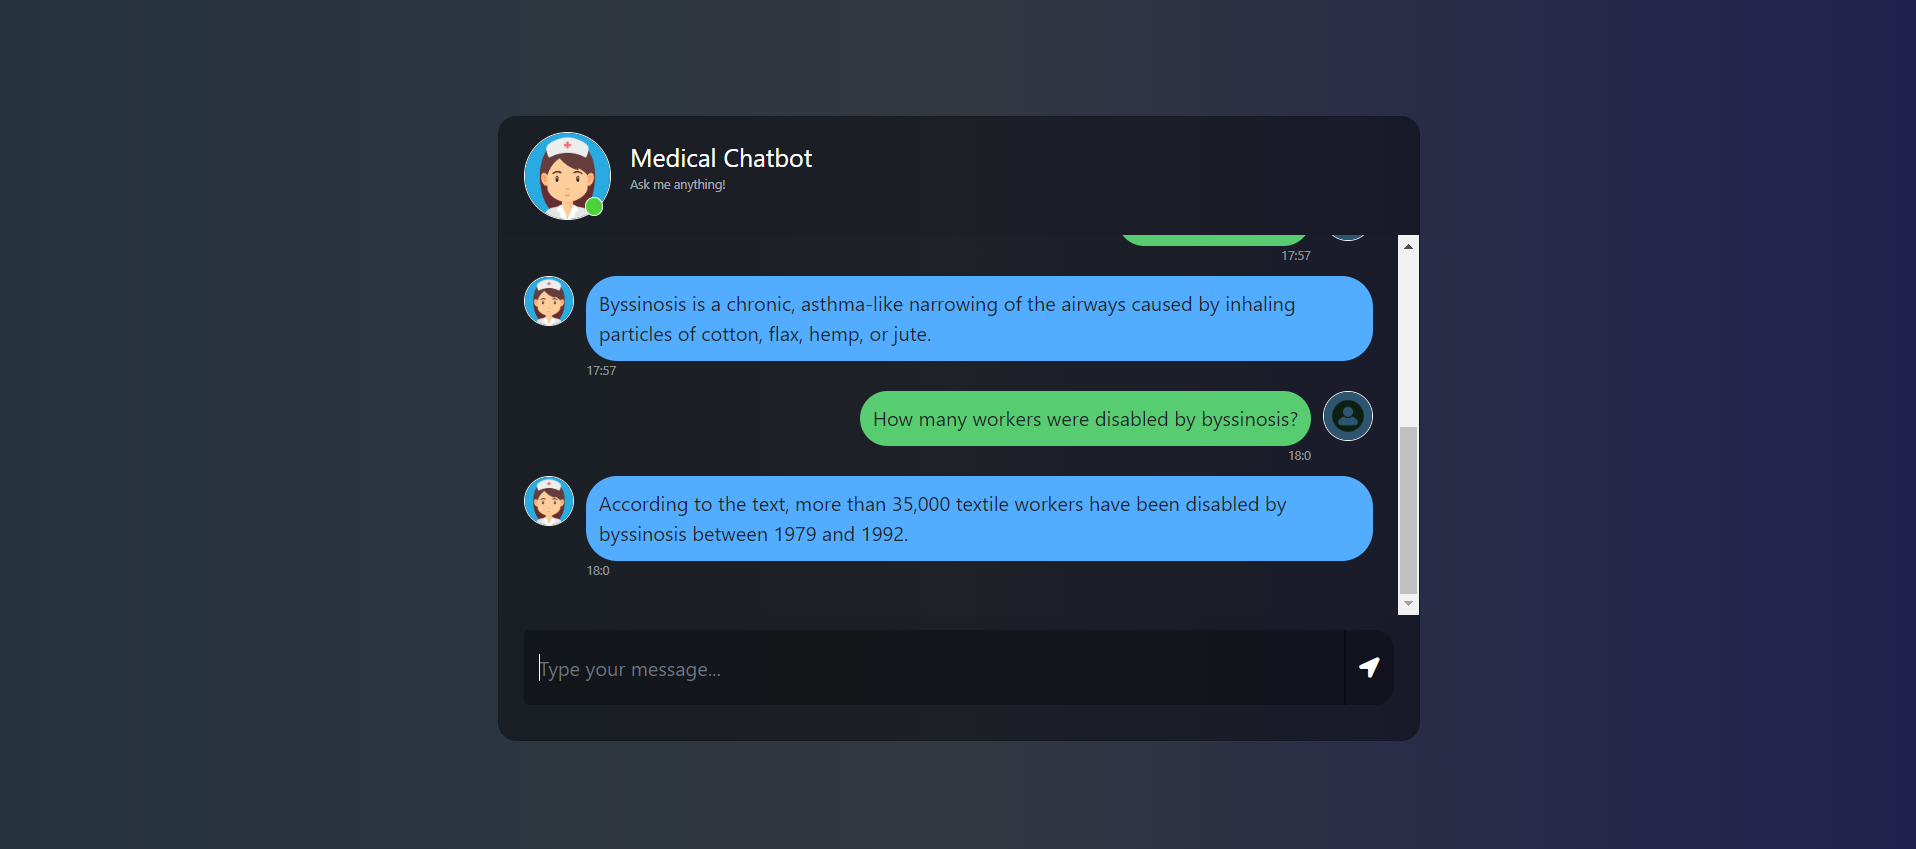

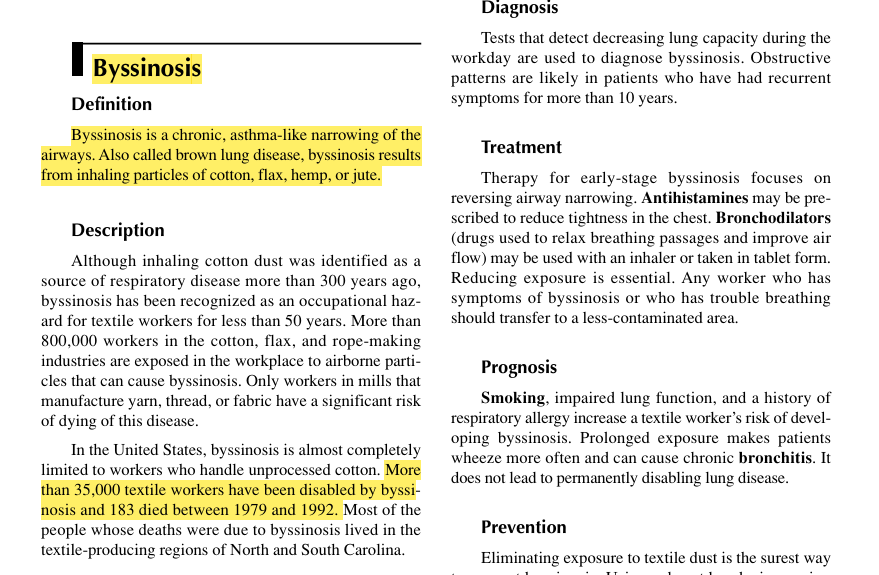